<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Game

A simplified version of Blackjack:
* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement).
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a color of red (probability 1/3) or black (probability 2/3).
* There are no aces or picture (face) cards in this game.
* At the start of the game, both the player and the dealer draw one black card (fully observed).

Actions:
* Each turn the player may either stick or hit.
* If the player hits then he or she draws another card from the deck.
* If the player sticks he or she receives no further cards.
* If the player sticks then the dealer starts taking turns.
* The dealer always sticks on any sum of 17 or greater, and hits otherwise.

Rules:
* The values of the player's cards are added (black cards) or subtracted (red cards).
* If the player's sum exceeds 21, or becomes less than 1, then he or she “goes bust" and loses the game (reward -1).
* If the dealer goes bust, then the player wins; otherwise, the outcome is the player with the largest sum.
* Reward $r ∈ \{+1, 0, -1\}$ for win, draw, and lose.

## Task 6.1

Write a function $(s′, r) = advance(s, a)$, which takes as input a state $s$ (dealer’s first card 1–10 and the player’s sum 1–21), and an action $a$ (hit or stick), and returns a sample of the next state $s′$ (which may be terminal if the game is finished) and reward $r ∈ \{1, 0, -1\}$ for winning, draw, and loosing. All non-terminal rewards are zero. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling $advance(s, stick)$ will play out the dealer’s cards and return the final reward and terminal state.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

In [ ]:
class Environment:
    def __init__(self):
        self.colors = (+1,-1)       # black -> +1, red -> -1
        self.colorP = (2/3, 1/3)    # probability of occurance
        self.values = range(1,11)   # 1 to 10, no picture cards
        self.stateSpace = (11,22)   # dealer's observed card x sum of card values
        self.nActions = 2           # stick -> 0, hit -> 1
    
    def reset(self):
        self.playerSum = self.drawCard(init=True)
        self.dealerSum = self.drawCard(init=True)
        return (self.dealerSum, self.playerSum)
    
    def drawCard(self, init=False):
        return np.random.choice(self.values) if init else \
                np.random.choice(self.values)*np.random.choice(self.colors, p=self.colorP)
    
    def advance(self, state, action):
        # if the player hits
        if action==1:
            # it draws another card
            self.playerSum += self.drawCard()
            # if player sum exceeds 21 or goes below 1, player loses (reward -1)
            # else reward 0 and the game continues
            return ((state[0],self.playerSum), 0, False) if 1<=self.playerSum<=21 else \
                    ((state[0],0), -1, True)
        # if the player sticks
        else:
            # the dealer starts taking turns
            while True:
                self.dealerSum += self.drawCard()
                # until it sticks
                if self.dealerSum >= 17:
                    break
            # the player wins if the dealer goes bust or
            # the dealer's sum is less than the player's sum
            if self.dealerSum > 21 or self.dealerSum < state[1]:
                return (state,1,True)
            # the player loses if the dealer's sum is greater
            # the match draws if both sums are equal
            else:
                return (state,-1,True) if self.dealerSum > state[1] else (state,0,True)

## Task 6.2

Implement Sarsa(λ) for the above game.

* Initialise the value function $Q(s, a)$ to zero.
* Use a time-varying scalar step-size of $α_t = 1/N(s_t, a_t)$ and an $ε$-greedy exploration strategy with $ε_t = N_0/(N_0+ N(s_t))$, where $N_0= 25$ is a constant, $N(s)$ is the number of times state s has been visited, and $N(s,a)$ is the number of times action a has been selected from state $s$.

In [ ]:
def epsGreedy(Qstate, nActions, epsilon):
    return np.random.choice(range(nActions)) if(np.random.random()<epsilon) else np.argmax(Qstate)

# SARSA-lambda
def policyImprovement(env, Q=None, lmbda=0.1, n0=25, gamma=1, episodes=10000):
    Q = np.zeros((*env.stateSpace,env.nActions)) if Q is None else Q
    eligibility = np.zeros(Q.shape)
    nQVisit = np.zeros(Q.shape, dtype=int)
    nSVisit = np.zeros(env.stateSpace, dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = env.reset()
        # get an action for the initial state using a policy derived from Q
        actionID = epsGreedy(Q[state], env.nActions, epsilon=n0/(n0+1))
        # repeat for each step of the episode
        while True:
            # take action and observe next state and reward
            state_, reward, done = env.advance(state, actionID)
            # get an action for the new state using a policy derived from Q
            nSVisit[state] += 1
            actionID_ = epsGreedy(Q[state], env.nActions, epsilon=n0/(n0+nSVisit[state]))
            nQVisit[state][actionID] += 1
            alpha = 1/nQVisit[state][actionID]
            tdError = reward + gamma*Q[state_][actionID_] - Q[state][actionID]
            eligibility[state][actionID] += 1
            # for each state-action pair
            for sa in np.ndindex(Q.shape):
                # update action value
                Q[sa] += alpha*eligibility[sa]*tdError
                # update eligibility trace
                eligibility[sa] *= gamma*lmbda
            # move on to the next state-action pair
            state = state_
            actionID = actionID_
            # until terminal state reached
            if done:
                break
    return Q


def plotStateValue(V):
    Z = V[1:,1:]
    x = np.arange(1, V.shape[1])
    y = np.arange(1, V.shape[0])
    X, Y = np.meshgrid(x,y)
    fig = plt.figure(figsize=Z.T.shape)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xlabel('Player Sum', fontsize=18)
    ax.set_ylabel('Dealer Showing', fontsize=18)
    ax.set_zlabel('Value', fontsize=18)
    ax.set_title('Optimal State-Value Function', fontsize=20)
    plot = ax.plot_surface(X, Y, Z, cmap='coolwarm')
    fig.colorbar(plot)

def plotActionValue(V):
    x = np.arange(1, V.shape[1])
    y = np.arange(1, V.shape[0])
    z = V[1:,1:]
    fig = plt.figure(figsize=z.shape)
    ax = fig.add_subplot(111)
    ax.grid(True, color='k', linewidth=2)
    ax.set_aspect(1)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xlabel('Player Sum', fontsize=16)
    ax.set_ylabel('Dealer Showing', fontsize=16)
    ax.set_title('Optimal Actions per State', fontsize=18)
    cmap = matplotlib.colors.ListedColormap(['dodgerblue', 'orangered'])
    plot = ax.imshow(z, cmap=cmap, extent=(1,V.shape[1],V.shape[0],1))
    cbar = fig.colorbar(plot, orientation='horizontal', pad=0.05, ticks=(0,1))
    cbar.ax.set_xticklabels(('Stick','Hit'), fontsize=16)
    plt.tight_layout()

Run the algorithm with parameter values $λ ∈ \{0, 0.1, 0.2, ..., 1\}$.

Stop exploration and learning after 1000 episodes and plot the accumulated reward for the next 100 episodes against λ.

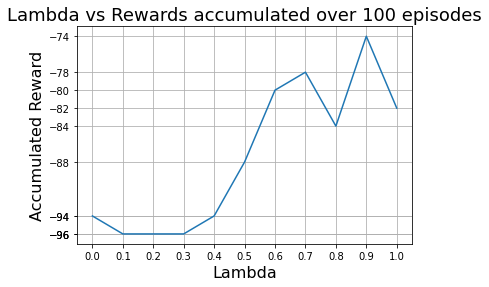

In [ ]:
env = Environment()
lmbdas = np.arange(0,1.1,0.1)
rewards = np.zeros(lmbdas.shape)
for i, lmbda in enumerate(lmbdas):
    Q = policyImprovement(env, lmbda=lmbda, episodes=1000)
    for _ in range(100):
        state=env.reset()
        while True:
            actionID = np.argmax(Q[state])
            nextState, reward, done = env.advance(state, actionID)
            rewards[i] += reward
            if done:
                break
print()
plt.plot(lmbdas,rewards)
plt.xticks(lmbdas)
plt.yticks(rewards)
plt.grid()
plt.xlabel('Lambda', fontsize=16)
plt.ylabel('Accumulated Reward', fontsize=16)
plt.title('Lambda vs Rewards accumulated over 100 episodes', fontsize=18)
plt.show()

Inspect optimal policy after learning for 10,000 episodes

100%|██████████| 10000/10000 [00:24<00:00, 405.24it/s]


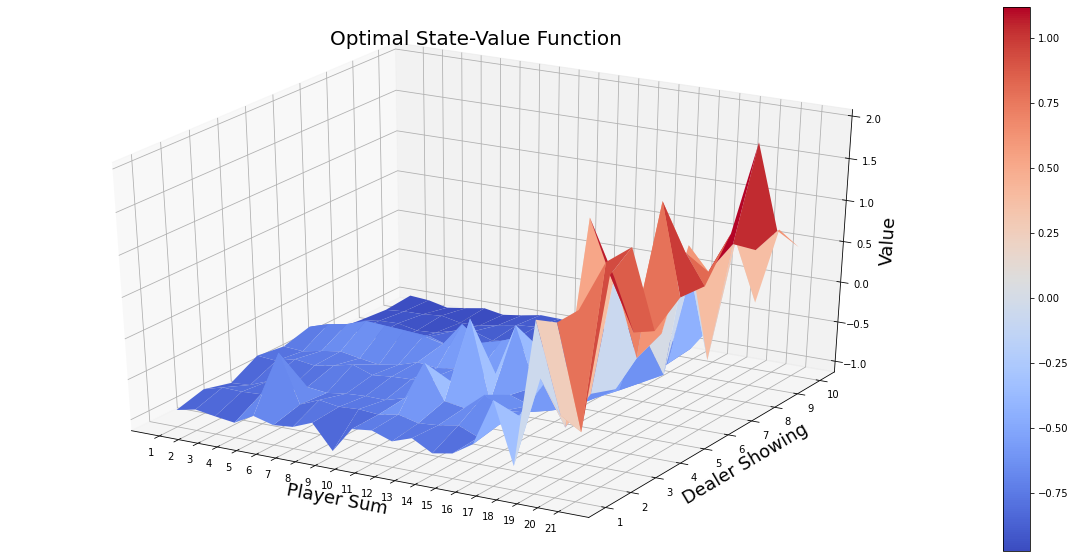

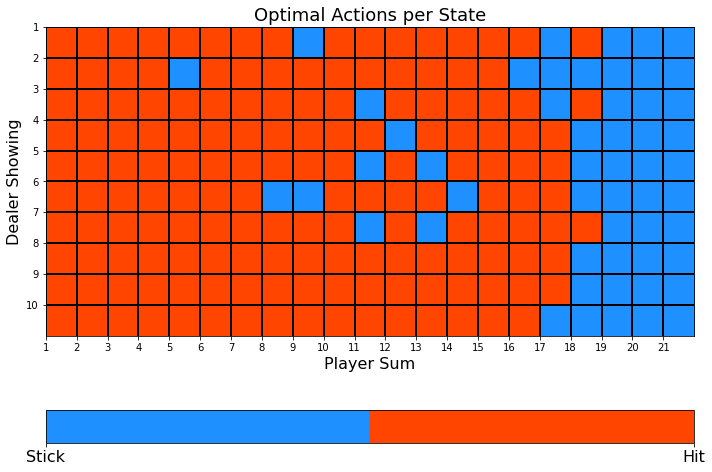

In [ ]:
Q = policyImprovement(Environment())
plotStateValue(np.amax(Q, axis=2))
plotActionValue(np.argmax(Q, axis=2))